![title](static/wcar.png)
#  Analysis of turnover mouse papers

    Wellcome Centre for Anti-Infectives Research
    School of Life Sciences, University of Dundee

This notebook analyse the experiment reported in Fornasiero et al., 2018 https://www.nature.com/articles/s41467-018-06519-0 and  Arike et al., 2020 https://www.sciencedirect.com/science/article/pii/S2211124719317255 papers for the determination of the protein turnover in mouse tissues.

# Final Conclusions
- We are going to deal with a sparse data, setting up a robust MS pipeline should be prioritized to get good data
- It is not convenient to start the analysis too early, probably 2 days is the earliest time point I would use. Too early and the data get rubish for a good fitting, I believe.
- if we manage to have a less sparse dataset we could use weight fitting to get more robust results
- Having 5 biological replica for each time point would be great, with the hope to get at least 3 measurements for each time point. This would make weight fitting feasible.
- the experimental design should focus on 6/7 time point with as many as possible bio replicates.
- Arike et al. 2020 switched on the re-quantitfy option in MaxQuant, I think this is wrong.
- the model of Arike et al. 2020 could be used for fitting to keep things easy. Anyway, both models require to quantify the amount of free lysine pool. Arike et al. 2020 offer a more straightforward method. On the other end, Fornasiero et al., 2018 looks more precise and authors suggests that the parameters they found could be applied to new experiments. 
- One question remains, does the free lysine pool changes between tissue? should not, but i think it is better to check experimentally. 

# Code to support Conclusions

In [1]:
#reload library if modified
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import utilities as PTUT
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters, report_fit

## Fornasiero et al., 2018
- we load and organize all the Fornasiero experiments in a common format.
- we have different preparation ( homogenate, SynapticVesicle and Synaptosome ) and brain area (Cere / Ctx)
- there are 3 technical and 3 biological experiments for each dataset

In [3]:
#set up the variables
path_to = 'PXD010859_2018/PXD010859/PRIDE-ZI/'
files = [
    'Homogenate_Cerebellum-Cortex-EE-C_proteinGroups.txt',
    'SynapticVesicle_Cerebellum-Cortex-EE-C_proteinGroups.txt',
    'Synaptosome_Cerebellum-Cortex-EE-C_proteinGroups.txt']

df_names = ['Homogenate','SynapticVesicle','Synaptosome']

header_dictionary = {
    'Homogenate':'Ratio H/L {loc}-{day}_H_{bio}R{tec}',
    'Synaptosome':'Ratio H/L {loc}-{day}d-Syn-{bio}R{tec}',
    'SynapticVesicle':'Ratio H/L {loc}-{day}d-{bio}R{tec}'
    
}

exp_dictionary = {
    'Homogenate' : ['Cere-C', 'Ctx-C','Ctx-EE'],
    'Synaptosome' : ['Cere-C', 'Ctx-C','Ctx-EE'],
    'SynapticVesicle':['Cere-SV-EE', 'Ctx-SV-C','Ctx-SV-EE', 'Cere-SV-C']
}

def parse_file(path_to, fname):
    print('\n')
    print('#### parsing '+fname+' #####')
    df = pd.read_csv(os.path.join(path_to,fname),sep='\t')
    #print(list(df.columns))
    df = PTUT.clean_df(df, score=False, unique_pep_threshold=2)
    df = PTUT.mod_df(df)
    #df.head()
    print(df.shape)
    return df



### Load Dataset

In [4]:
forn_dict = {}
for fname,name in zip(files,df_names):
    forn_dict[name]=parse_file(path_to, fname)



#### parsing Homogenate_Cerebellum-Cortex-EE-C_proteinGroups.txt #####
starting from: (5876, 1338)
removed  149 Protein Groups by: Only identified by site
tot  149  entries removed
---------------
Reverse
nothing removed
---------------
removed  5 Protein Groups by: Potential contaminant
tot  154  entries removed
---------------
removed  215 Protein Groups by: Peptide counts (unique)
tot  369  entries removed
---------------
(5507, 1341)


#### parsing SynapticVesicle_Cerebellum-Cortex-EE-C_proteinGroups.txt #####
starting from: (5366, 1443)
removed  214 Protein Groups by: Only identified by site
tot  214  entries removed
---------------
Reverse
nothing removed
---------------
removed  4 Protein Groups by: Potential contaminant
tot  218  entries removed
---------------
removed  132 Protein Groups by: Peptide counts (unique)
tot  350  entries removed
---------------
(5016, 1446)


#### parsing Synaptosome_Cerebellum-Cortex-EE-C_proteinGroups.txt #####
starting from: (6126, 1092)
remov

In [5]:
#data structure to keep experiments
forn_experiments = {}
forn_experiments['SynapticVesicle']={}
forn_experiments['Synaptosome']={}
forn_experiments['Homogenate']={}

In [6]:
#load and process each experiment
for exp_class in df_names:
    print('parsing', exp_class)
    for l in exp_dictionary[exp_class]:
        print('extract', l.replace('-SV-','-'))
        
        df = forn_dict[exp_class].copy()
        #print(df.head())
        
        
    #for l in ['Cere-C', 'Ctx-C','Ctx-EE']:
        days = ['5','14','21']
        replicates = ['1','2','3']

        header_template = header_dictionary[exp_class]#'Ratio H/L {loc}-{day}_H_{bio}R{tec}'

        headers = []
        for d in days:
            for b in replicates:
                for t in replicates:
                    header = header_template.format(
                        loc=l,
                        day=d,
                        bio=b,
                        tec=t)
                    headers.append(header)

        #print(l, headers)
        selection = df[headers][~df[headers].isnull().all(1)]
        print(selection.shape)
        selection.columns = [n.replace('Ratio H/L '+l+'-','') for n in selection.columns]
        selection.columns = [n.replace('-Syn-','-') for n in selection.columns]
        selection.columns = [n.replace('_H_','d-') for n in selection.columns]

        ria = selection/(1+(selection))
        #ria = selection/(1+(selection))
        #ria.columns = [n.upper() for n in ria.columns]
        
        forn_experiments[exp_class].update({l.replace('-SV-','-'):ria}) 
    

parsing Homogenate
extract Cere-C
(2780, 27)
extract Ctx-C
(2410, 27)
extract Ctx-EE
(2514, 27)
parsing SynapticVesicle
extract Cere-EE
(1688, 27)
extract Ctx-C
(2764, 27)
extract Ctx-EE
(2213, 27)
extract Cere-C
(2430, 27)
parsing Synaptosome
extract Cere-C
(1868, 27)
extract Ctx-C
(3073, 27)
extract Ctx-EE
(1375, 27)


### Missing Values
- we visualize the number of missing value for each experiments

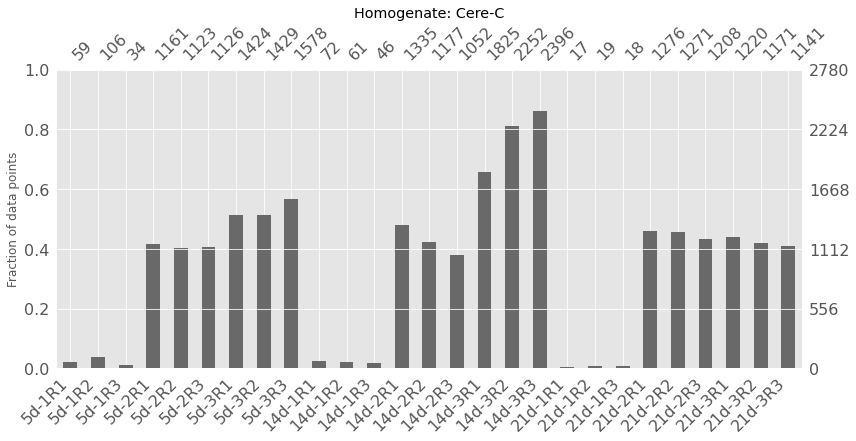

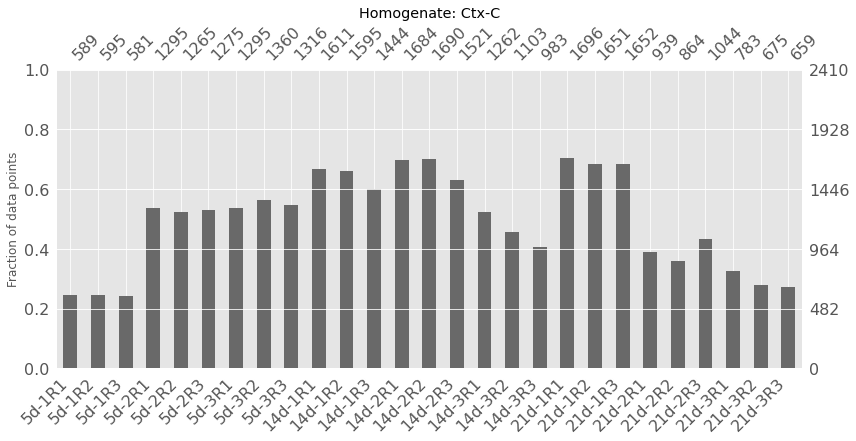

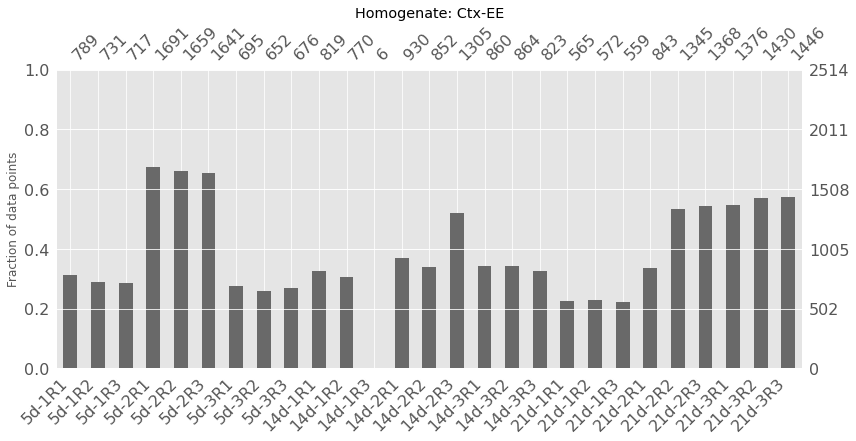

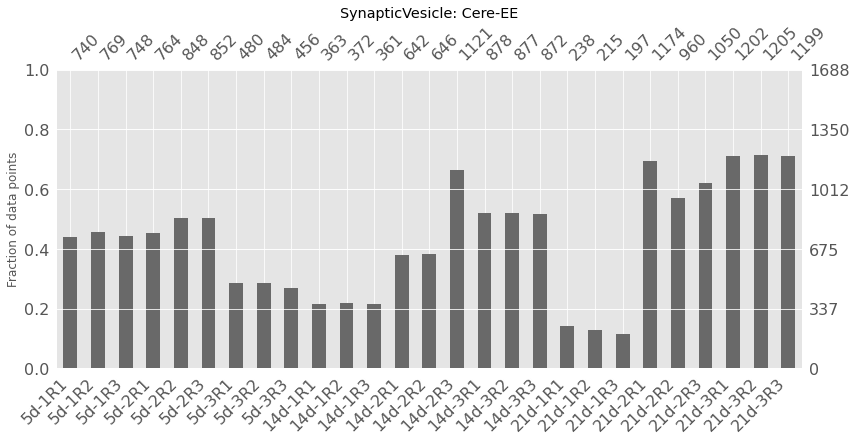

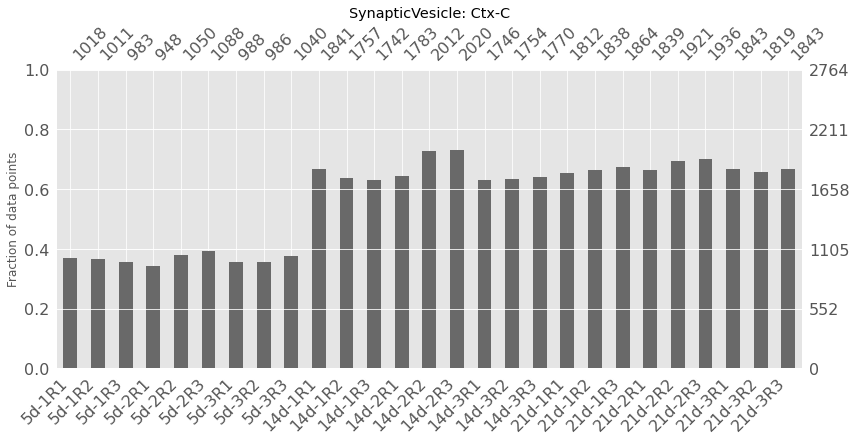

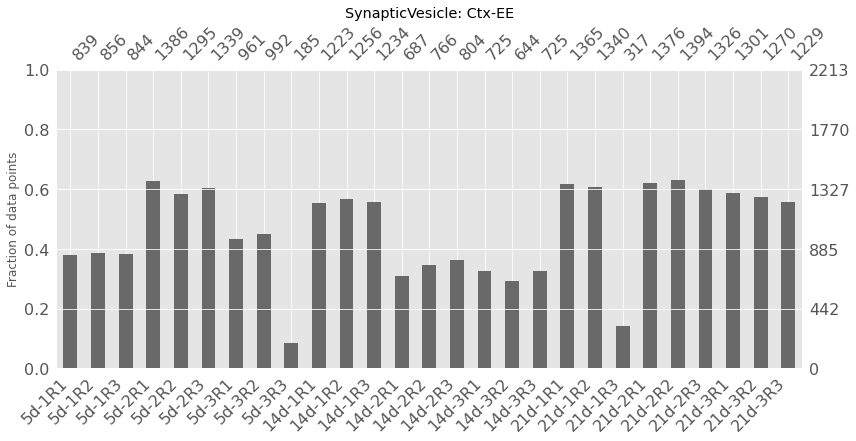

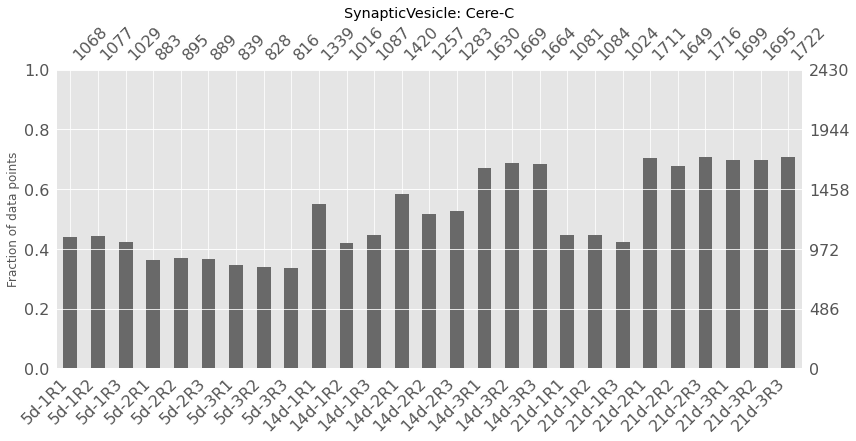

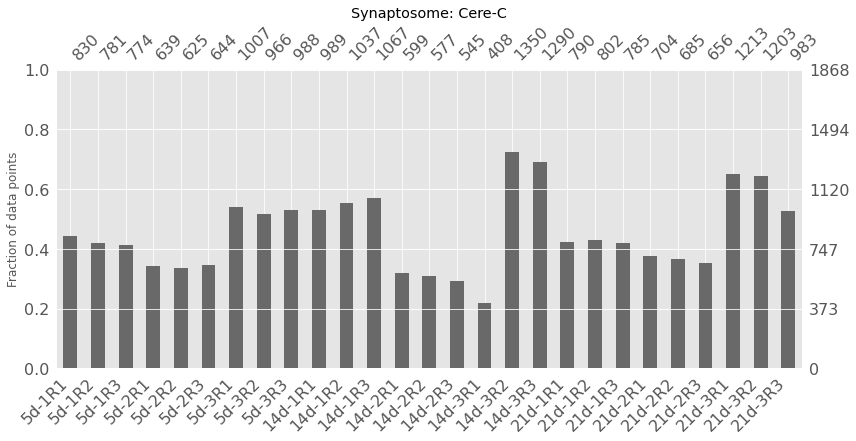

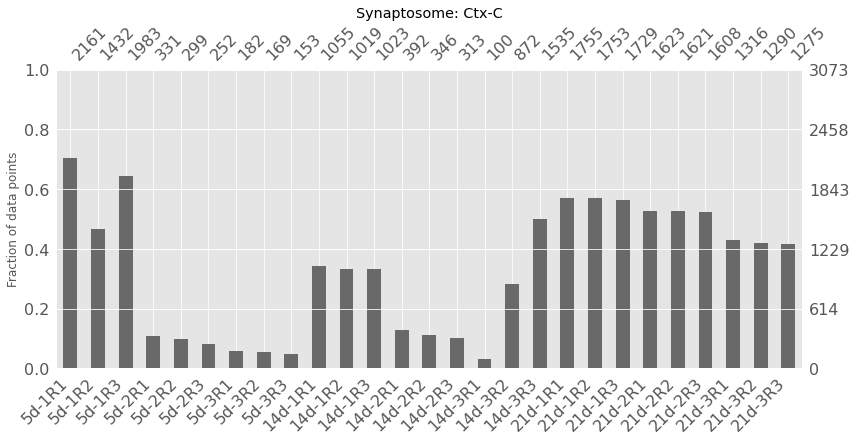

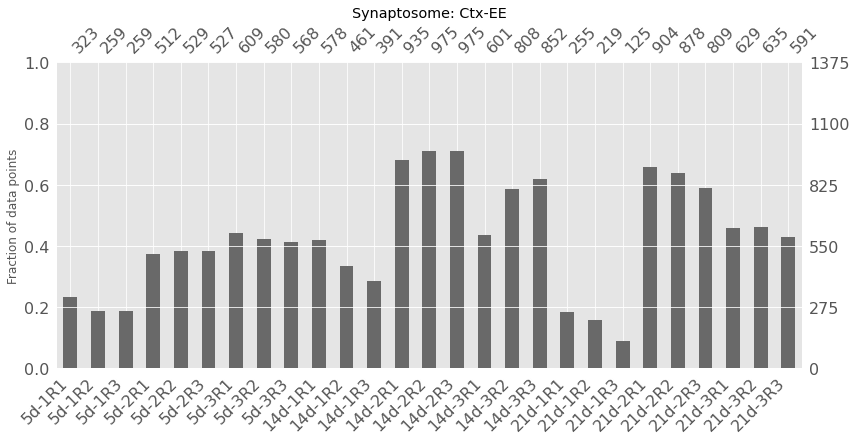

In [7]:
for exp_class in df_names:
    for exp in forn_experiments[exp_class].keys():
        #visualization of missing data
        ax=msno.bar(forn_experiments[exp_class][exp],figsize=(12, 6))
        #plt.title('Missing Data Analysis',size=12)
        ax.set_ylabel('Fraction of data points',size=12)
        plt.tight_layout()
        plt.title(exp_class+': '+exp)
        plt.show()

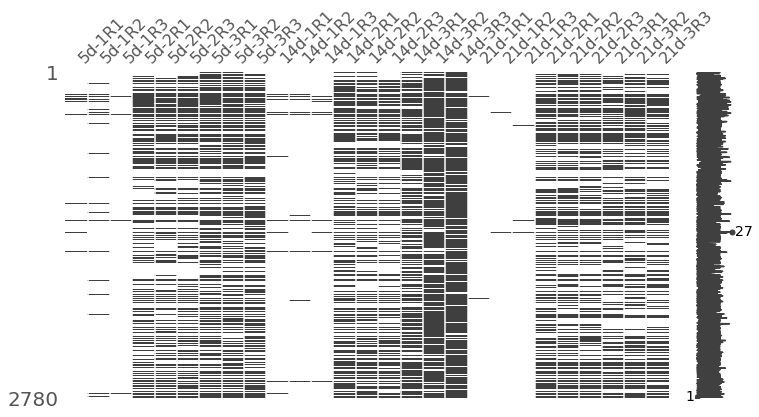

In [8]:
#lets get a closer look to an experiment.
#it looks like something went wrong with all
#the first biological replicates
msno.matrix(forn_experiments['Homogenate']['Cere-C'], figsize=(12, 6))
plt.show()

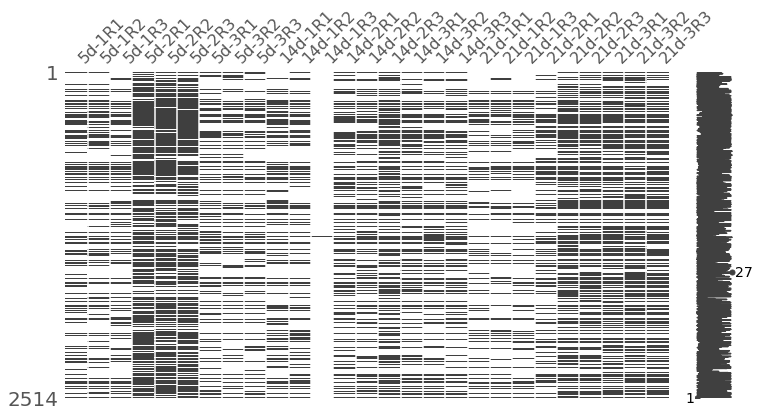

In [9]:
#lets get a closer look to an experiment.
#it looks like something went wrong with just one technical
msno.matrix(forn_experiments['Homogenate']['Ctx-EE'], figsize=(12, 6))
plt.show()

#### Conclusion 
It appears that the data is very sparse, looks like a mixture of sloppy practice and difficulties in quantify the proteins in a relaiable manner.

## Implementing degradation models

### Implement Arike et al. 2020 model

Protein turnover rate 0.05743970101681365
half-life 12.067388379285756


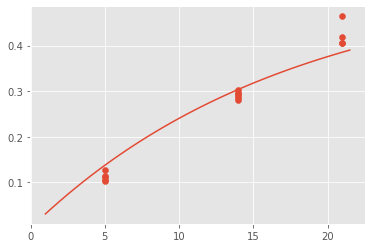

In [12]:
df = forn_dict['Homogenate'].copy()


index_prot = df[df['Protein IDs'].str.contains('P23819')]
index_prot = index_prot.index.values[0]
temp_df = forn_experiments['Homogenate']['Cere-C']
#temp_prot = 100 - (temp_df.loc[index_prot]*100)
temp_prot = pd.DataFrame()
temp_prot['Day']=[int(n.split('-')[0].replace('d','')) for n in temp_df.columns]
temp_prot['RIA']= temp_df.loc[index_prot].values
temp_prot = temp_prot.dropna()

#apdt = average protein degradation time
#Protein turnover rate = log(2)/apdt
def exp_dec_model(x, params):
    apdt = params['apdt'].value
    return 0.55 * (1 - np.exp( - (np.log(2)/apdt) * x ))

#exponential decay, resids is the quantity to minimize 
def residual(params, x, data):
    """minimize exp decay"""
    apdt = params['apdt']
    model = 0.55 * (1 - np.exp( - (np.log(2)/apdt) * x ))
    resids = model - data
    return resids


params = Parameters()
params.add('apdt', value=1)
x = temp_prot['Day'].values
data = temp_prot['RIA'].values
out_fit = minimize(residual, params, args=(x, data))


fig,ax=plt.subplots()
#temp_prot.plot(kind='scatter',x='Day',y='RIA',ax=ax)
x = np.arange(1,22,0.5)
y = exp_dec_model(x, out_fit.params)
ax.plot(x,y)
ax.scatter(temp_prot['Day'],temp_prot['RIA'])
print('Protein turnover rate',np.log(2)/out_fit.params['apdt'])
print('half-life',out_fit.params['apdt']*1)
out_fit
#'Q62277'
#Protein turnover rate 0.03679120221182291
#half-life 18.840025301951165

### Implement Fornasiero et al., 2018

0.5028654927036859 1.1530312053389136 56.876232152365084
half-life 11.851109784276684


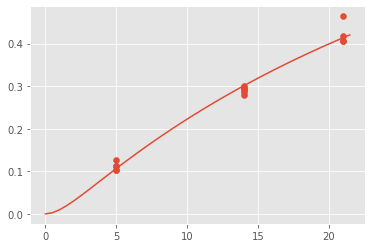

In [11]:

a = 0.0342767364 #(a) protein degradation rate
b = 0.4448654275 #(b) lysine feeding / excretion rate
r = 11.8365728939 #(r) ratio of protein / lysine pool size;
C = np.sqrt(-4*a*b + (a+b+a*r)**2)
t1 = 2/(a+b+a*r+C)
t2 = 2/(a+b+a*r-C)
A  = -(a-b+a*r-C)/(2*C)


print(A,t1,t2)
#A=0.503
#t1=0.799
#t2=39.423

def exp_dec_model(t, params):
    tp = params['tp'].value
    return -np.exp(-t/tp)*(-(A*t1)/(t1-tp)+(t2*(A-1.0))/(t2-tp)+1.0)+np.exp(-t/tp)*(np.exp(t/tp)-(A*t1*np.exp(-t/t1+t/tp))/(t1-tp)+(t2*np.exp(-t/t2+t/tp)*(A-1.0))/(t2-tp))


#exponential decay, resids is the quantity to minimize 
def residual(params, t, data):
    """minimize exp decay"""
    tp = params['tp'].value
    model = -np.exp(-t/tp)*(-(A*t1)/(t1-tp)+(t2*(A-1.0))/(t2-tp)+1.0)+np.exp(-t/tp)*(np.exp(t/tp)-(A*t1*np.exp(-t/t1+t/tp))/(t1-tp)+(t2*np.exp(-t/t2+t/tp)*(A-1.0))/(t2-tp))
    resids = model - data
    return resids


df = forn_dict['Homogenate'].copy()
index_prot = df[df['Protein IDs'].str.contains('P23819')]
index_prot = index_prot.index.values[0]
temp_df = forn_experiments['Homogenate']['Cere-C']
#temp_prot = 100 - (temp_df.loc[index_prot]*100)
temp_prot = pd.DataFrame()
temp_prot['Day']=[int(n.split('-')[0].replace('d','')) for n in temp_df.columns]
temp_prot['RIA']= temp_df.loc[index_prot].values
temp_prot = temp_prot.dropna()

params = Parameters()
params.add('tp', value=1, min=0.25, max=1000)
x = temp_prot['Day'].values
data = temp_prot['RIA'].values
out_fit = minimize(residual, params, args=(x, data))


fig,ax=plt.subplots()
#temp_prot.plot(kind='scatter',x='Day',y='RIA',ax=ax)
x = np.arange(0,22,0.5)
y = exp_dec_model(x, out_fit.params)
ax.plot(x,y)
ax.scatter(temp_prot['Day'],temp_prot['RIA'])
print('half-life',np.log(2)*out_fit.params['tp'])
out_fit

### Conclusion
the models give similar results however, Arike et al. 2020 model is easier to anderstand and implement

## Visualise Q62277 (synaptophysin)

- we visualize the model fitting and half-life for all the Fornasiero et al., 2018 experiments using the Arike et al. 2020 model
- the model result of Fornasiero et al., 2018 (Supplementary Fig. 5) is reported for comparison
https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-018-06519-0/MediaObjects/41467_2018_6519_MOESM1_ESM.pdf
- we will use two proteins for comparison

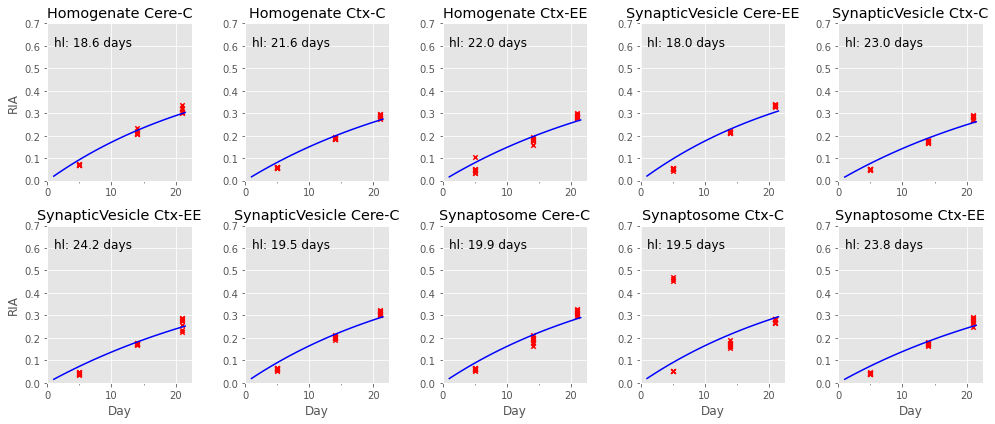

In [13]:
fig,axes = plt.subplots(2,5,figsize=(14,6))
prot = 'Q62277'
a=0
for df_name in df_names: 
    df = forn_dict[df_name]
    #print(df.head())
    index_prot = df[df['Protein IDs'].str.contains(prot)]
    index_prot = index_prot.index.values[0]
    #print(df_name, index_prot)
    
    for exp in forn_experiments[df_name].keys():
        
        temp = pd.DataFrame()
        
        temp_df = forn_experiments[df_name][exp]
        if index_prot in temp_df.index.values:
            temp['Day']=[int(n.split('-')[0].replace('d','')) for n in forn_experiments[df_name][exp].columns]
            temp['RIA']=forn_experiments[df_name][exp].loc[index_prot].values
            temp = temp.dropna()
            params = Parameters()
            params.add('apdt', value=1)
            x = temp['Day'].values
            data = temp['RIA'].values
            out_fit = minimize(residual, params, args=(x, data))
            
            x = np.arange(1,22,0.5)
            y = exp_dec_model(x, out_fit.params)
            
            
            temp.head()
            #fig,ax=plt.subplots(figsize=(0,6))
            if a>4:
                index_col = a-5
                index_row = 1
            else:
                index_col = a
                index_row = 0
                
            #print(index_row,index_col)
            
            temp.plot(kind='scatter', x='Day', y='RIA',marker='x',c='r',ax=axes[index_row,index_col])
            axes[index_row,index_col].set_ylim(0,100)
            axes[index_row,index_col].set_xticks([0,5,10,15,20,25],[0,5,10,15,20,25])
            axes[index_row,index_col].set_yticks([10,20,30,40,50,60,70,80,90,100],[10,20,30,40,50,60,70,80,90,100])
            axes[index_row,index_col].set_title(df_name+' '+exp)
            axes[index_row,index_col].plot(x,y,c='b')
            #print('half-life',out_fit.params['apdt']*1)
            hl=round(out_fit.params['apdt']*1,1)
            axes[index_row,index_col].text(1, 0.6, 'hl: '+str(hl)+' days', fontsize=12)
            
            #
            a+=1
            axes[index_row,index_col].set_ylim(0,0.7)
            if index_row == 0:
                axes[index_row,index_col].set_xlabel('')
            if index_col > 0:
                axes[index_row,index_col].set_ylabel('')
                
        else:
            print(df_name, exp,'not found')
            a+=1

plt.tight_layout()


<img src="Q62277.png" alt="Drawing" style="width: 200px;"/>

### Visualise P23819 (Glutamate receptor 2)

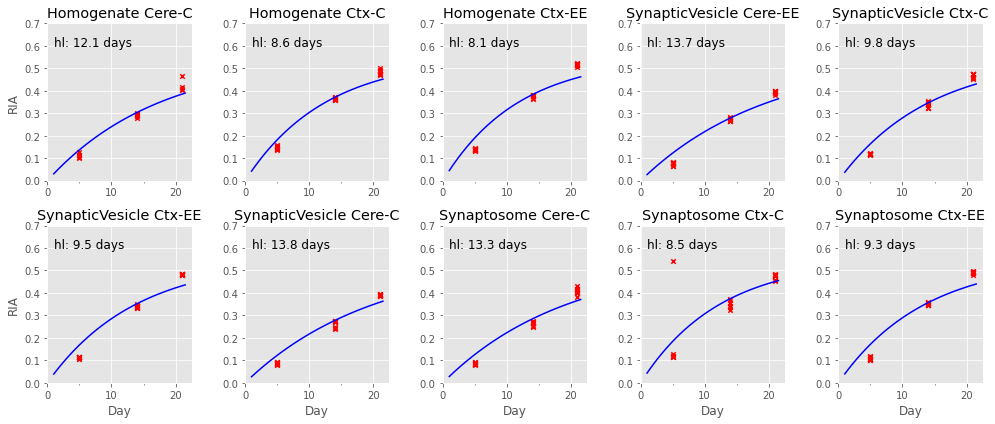

In [14]:
fig,axes = plt.subplots(2,5,figsize=(14,6))
prot = 'P23819'
a=0
for df_name in df_names: 
    df = forn_dict[df_name]
    #print(df.head())
    index_prot = df[df['Protein IDs'].str.contains(prot)]
    index_prot = index_prot.index.values[0]
    #print(df_name, index_prot)
    
    for exp in forn_experiments[df_name].keys():
        
        temp = pd.DataFrame()
        
        temp_df = forn_experiments[df_name][exp]
        if index_prot in temp_df.index.values:
            temp['Day']=[int(n.split('-')[0].replace('d','')) for n in forn_experiments[df_name][exp].columns]
            temp['RIA']=forn_experiments[df_name][exp].loc[index_prot].values
            temp = temp.dropna()
            params = Parameters()
            params.add('apdt', value=1)
            x = temp['Day'].values
            data = temp['RIA'].values
            out_fit = minimize(residual, params, args=(x, data))
            
            x = np.arange(1,22,0.5)
            y = exp_dec_model(x, out_fit.params)
            
            
            temp.head()
            #fig,ax=plt.subplots(figsize=(0,6))
            if a>4:
                index_col = a-5
                index_row = 1
            else:
                index_col = a
                index_row = 0
                
            #print(index_row,index_col)
            
            temp.plot(kind='scatter', x='Day', y='RIA',marker='x',c='r',ax=axes[index_row,index_col])
            axes[index_row,index_col].set_ylim(0,100)
            axes[index_row,index_col].set_xticks([0,5,10,15,20,25],[0,5,10,15,20,25])
            axes[index_row,index_col].set_yticks([10,20,30,40,50,60,70,80,90,100],[10,20,30,40,50,60,70,80,90,100])
            axes[index_row,index_col].set_title(df_name+' '+exp)
            axes[index_row,index_col].plot(x,y,c='b')
            #print('half-life',out_fit.params['apdt']*1)
            hl=round(out_fit.params['apdt']*1,1)
            axes[index_row,index_col].text(1, 0.6, 'hl: '+str(hl)+' days', fontsize=12)
            
            #
            a+=1
            axes[index_row,index_col].set_ylim(0,0.7)
            if index_row == 0:
                axes[index_row,index_col].set_xlabel('')
            if index_col > 0:
                axes[index_row,index_col].set_ylabel('')
                
        else:
            print(df_name, exp,'not found')
            a+=1

plt.tight_layout()

<img src="P23819.png" alt="Drawing" style="width: 200px;"/>

#### Conclusion
the model from Arike et al. 2020 can be applied to the Fornasiero et al., 2018 

## Coefficent of variation
- the Fornasiero et al., 2018 use 3 bio and 3 technical replicates, we can compute the coefficent of variation for all the experiments.

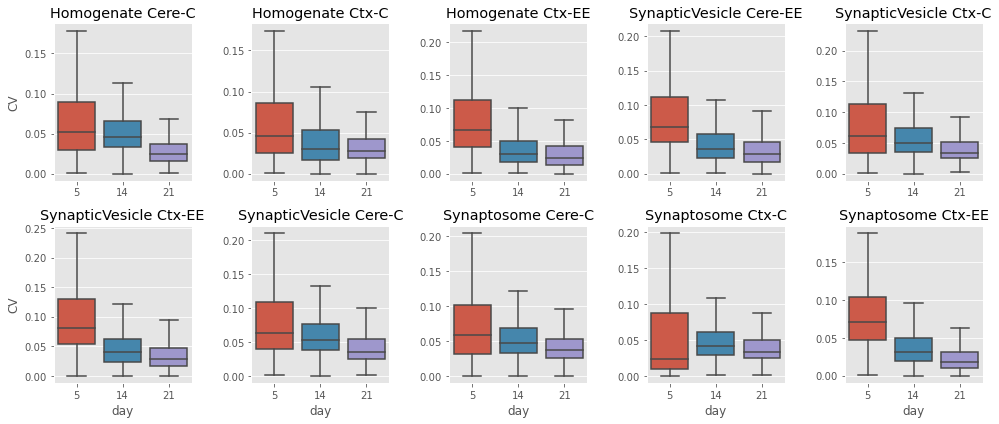

In [15]:
fig,axes = plt.subplots(2,5,figsize=(14,6))
a=0
for df_name in df_names: 
    df = forn_dict[df_name]
    for exp in forn_experiments[df_name].keys():
        temp_df = forn_experiments[df_name][exp]
        
        cv_df = []
        for col in temp_df.columns:
            temp = temp_df[col].reset_index()
            temp.columns = ['genes','ria']
            temp['day'] = int(col.split('-')[0].replace('d',''))
            cv_df.append(temp)

        cv_df=pd.concat(cv_df)    
        cv_df = cv_df.groupby(['genes','day'])['ria'].std()/cv_df.groupby(['genes','day'])['ria'].mean()
        cv_df = cv_df.reset_index()
        cv_df=cv_df.rename({'ria':'CV'},axis=1)
        
        if a>4:
            index_col = a-5
            index_row = 1
        else:
            index_col = a
            index_row = 0        
        
        sns.boxplot(data = cv_df, x= 'day',y='CV',showfliers=False,ax=axes[index_row,index_col])
        
        #axes[index_row,index_col].set_ylim(0,70)
        if index_row == 0:
            axes[index_row,index_col].set_xlabel('')
        if index_col > 0:
            axes[index_row,index_col].set_ylabel('')
        axes[index_row,index_col].set_title(df_name+' '+exp)
        
        
        a+=1
        
plt.tight_layout()

#### Conclusion
- As expected, the earliest time points with low amount of heavy label are more difficoult to quantify (higher cv).
- At 5 days the cv is > 5% for a tissue with slow turnover. Probably is better to have earlier time points only for tissues with high turnover

## Arike et al. 2020
- we load and organize all the Arike et al. 2020 dataset in a common format.
- we have different preparation of intestine regions ( 'DCE','DCM','DE','IE','IM','MJE','PCE' ) with no time point replica.
- The protein turnover of normal mouse and germ free mouse are compared.

In [16]:
path_to = 'PXD011457/{f_name} MaxQuant/txt/'

df_names = ['CR','GF']
Arike_dict = {}
for name in df_names:
    Arike_dict[name]=parse_file(path_to.format(f_name=name), 'proteinGroups.txt')    



#### parsing proteinGroups.txt #####
starting from: (5956, 920)
removed  49 Protein Groups by: Only identified by site
tot  49  entries removed
---------------
removed  58 Protein Groups by: Reverse
tot  107  entries removed
---------------
removed  39 Protein Groups by: Contaminant
tot  146  entries removed
---------------
removed  748 Protein Groups by: Peptide counts (unique)
tot  894  entries removed
---------------
(5062, 923)


#### parsing proteinGroups.txt #####
starting from: (5361, 822)
removed  23 Protein Groups by: Only identified by site
tot  23  entries removed
---------------
removed  52 Protein Groups by: Reverse
tot  75  entries removed
---------------
removed  55 Protein Groups by: Contaminant
tot  130  entries removed
---------------
removed  517 Protein Groups by: Peptide counts (unique)
tot  647  entries removed
---------------
(4714, 825)


In [17]:
exp_dictionary = {
    'CR' : ['DCE','DCM','DE','IE','IM','MJE','PCE'],
    'GF' : ['DCE','DCM','DE','IE','IM','MJE','PCE'],
    
}

Arike_experiments = {}
Arike_experiments['CR']={}
Arike_experiments['GF']={}


header_dictionary = {
    'CR':'Ratio H/L {loc}_{day}D',
    'GF':'Ratio H/L {loc}_GF_{day}D',
    
}

days_dictionary = {
   'CR': ['0','1','3','4','5','7','10','14','32'],
   'GF':['0','1','2','3','7','10','14','31']
}



### load Dataset

In [18]:
for exp_class in ['CR','GF']:
    print('parsing', exp_class)
    for l in exp_dictionary[exp_class]:
        #print('extract', l)
        
        df = Arike_dict[exp_class].copy()
        #print(df.head())
        
        header_template = header_dictionary[exp_class]#'Ratio H/L {loc}-{day}_H_{bio}R{tec}'

        headers = []
        for d in days_dictionary[exp_class]:
            header = header_template.format(
                        loc=l,
                        day=d)
            headers.append(header)

        #print(l, headers)
        selection = df[headers][~df[headers].isnull().all(1)]
        #print(selection.shape)
        selection.columns = [n.replace('Ratio H/L '+l+'_','') for n in selection.columns]
        selection.columns = [n.replace('GF_','') for n in selection.columns]
        #print(selection.columns)
        #selection.columns = [n.replace('_H_','d-') for n in selection.columns]

        ria = selection*2/(1+(selection*2))
        #ria = selection/(1+(selection))
        #ria.columns = [n.upper() for n in ria.columns]
        
        Arike_experiments[exp_class].update({l:ria}) 
    

parsing CR
parsing GF


### Missing Values
we have a situation similar to Fornasiero et al., 2018, sparse dataset with some samples that clearly went wrong

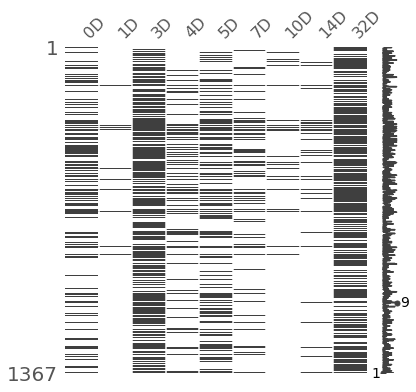

In [19]:
#lets get a closer look to the one intestine reagion of the nomal mouse 
msno.matrix(Arike_experiments['CR']['IM'], figsize=(6, 6))
plt.show()

#### raw file QC
We can see from the raw file QC that the 1D sample of the normal mouse is made of spring water

![title](PXD011457/130708_01_QEx_LA_IM_1D.raw.png)

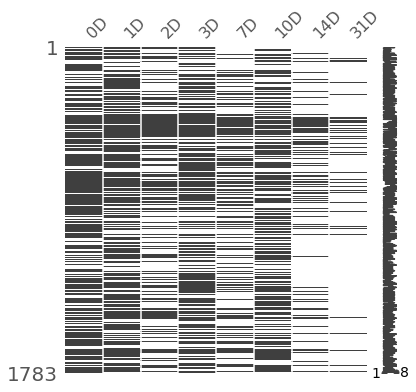

In [20]:
#the same intestine reagion of the germ free mouse seems to have problem at 31D. 
#Howewer the 1D sample looks good
msno.matrix(Arike_experiments['GF']['IM'], figsize=(6, 6))
plt.show()

![title](PXD011457/131018_35_QEx_LA_GF_IM_1D.raw.png)

### Visualize Missing value for all Arike et al. 2020

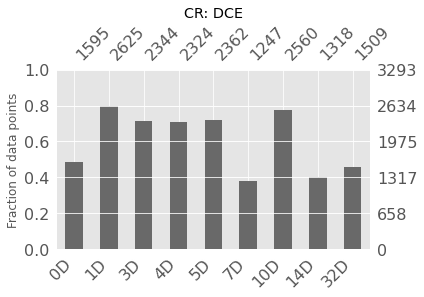

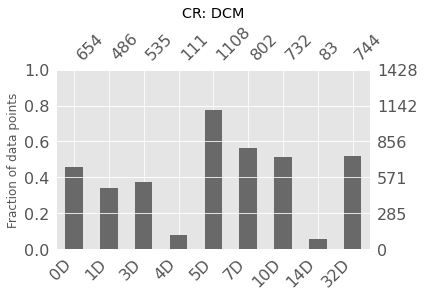

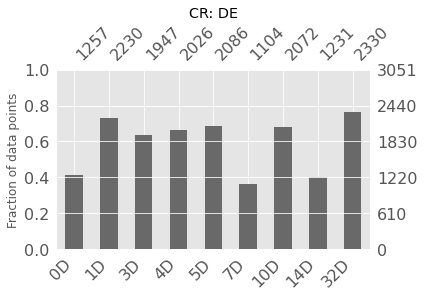

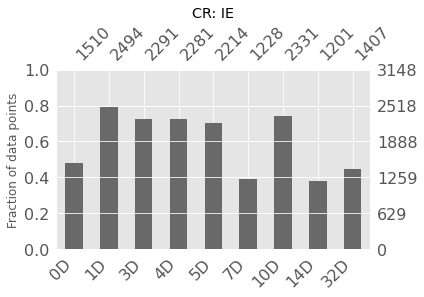

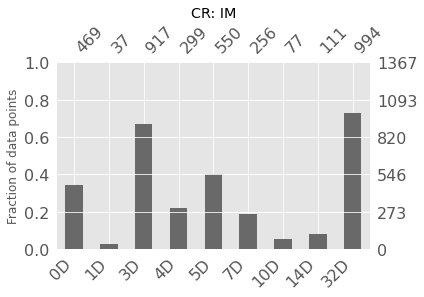

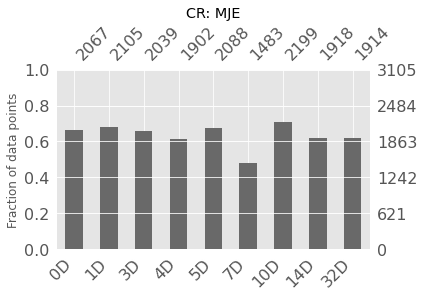

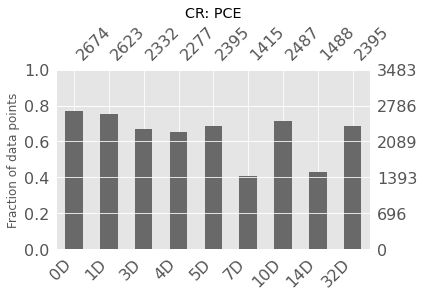

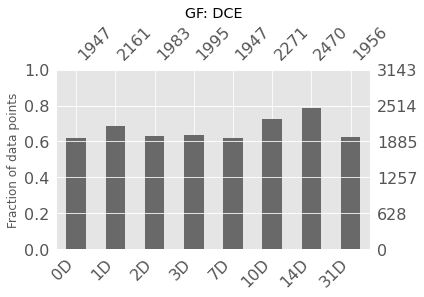

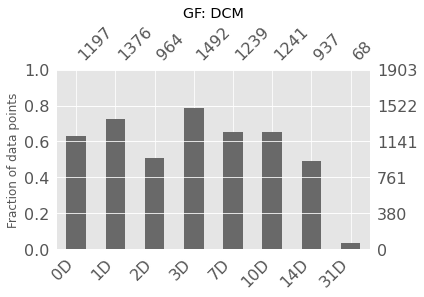

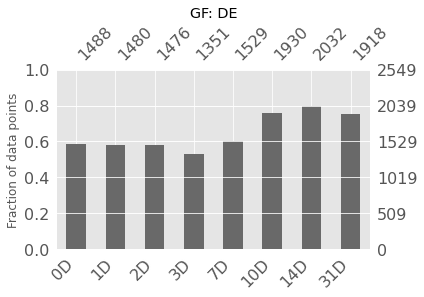

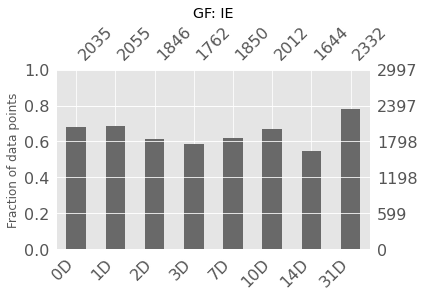

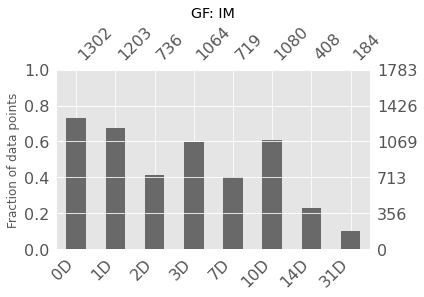

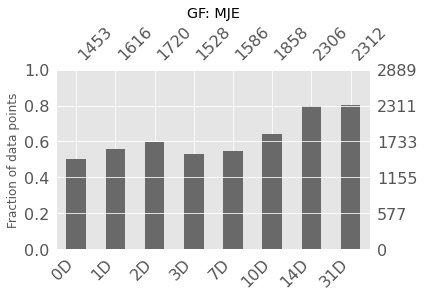

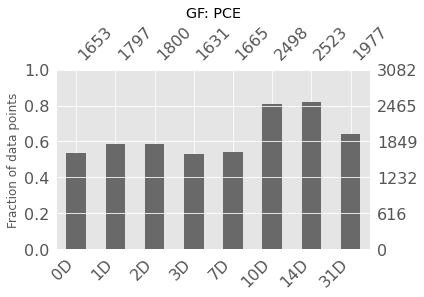

In [21]:
for exp_class in ['CR','GF']:
    for exp in Arike_experiments[exp_class].keys():
        #visualization of missing data
        ax=msno.bar(Arike_experiments[exp_class][exp],figsize=(6, 4))
        #plt.title('Missing Data Analysis',size=12)
        ax.set_ylabel('Fraction of data points',size=12)
        plt.tight_layout()
        plt.title(exp_class+': '+exp)
        plt.show()

In [22]:
!jupyter nbconvert --to html_toc turnover_analysis.ipynb

[NbConvertApp] Converting notebook turnover_analysis.ipynb to html_toc
[NbConvertApp] Support files will be in turnover_analysis_files/
[NbConvertApp] Making directory turnover_analysis_files
[NbConvertApp] Making directory turnover_analysis_files
[NbConvertApp] Making directory turnover_analysis_files
[NbConvertApp] Making directory turnover_analysis_files
[NbConvertApp] Making directory turnover_analysis_files
[NbConvertApp] Making directory turnover_analysis_files
[NbConvertApp] Making directory turnover_analysis_files
[NbConvertApp] Making directory turnover_analysis_files
[NbConvertApp] Making directory turnover_analysis_files
[NbConvertApp] Making directory turnover_analysis_files
[NbConvertApp] Making directory turnover_analysis_files
[NbConvertApp] Making directory turnover_analysis_files
[NbConvertApp] Making directory turnover_analysis_files
[NbConvertApp] Making directory turnover_analysis_files
[NbConvertApp] Making directory turnover_analysis_files
[NbConvertApp] Making di